In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('datacollection.csv')
data.head()

,NumComments,Flair,Upvotes,UpvoteRatio,Over18,Media,Body,Title,URL,ID
0,300,Culture,5397,0.94,False,NaN,NaN,Finally convinced dad to remove plastic covers...,https://i.redd.it/9augyh3dgtf91.jpg,wgkyvg
1,62,Sports,4394,0.99,False,NaN,NaN,Avinash Sable - Remember the name,https://i.redd.it/62a5jcutt4g91.png,whu852
2,151,Science,3932,0.99,False,"{'reddit_video': {'bitrate_kbps': 2400, 'fallb...",NaN,Science class at Punjab.,https://v.redd.it/g0ggxwe8vvf91,wgtft4
3,335,Politics,3771,0.88,False,NaN,NaN,How Freedom Fighters would be treated today,https://i.redd.it/qxo9lcmm3ng91.jpg,wjwwb8
4,83,Sports,3326,0.97,False,NaN,NaN,Unbelievable stuff happening in Commonwealth g...,https://i.redd.it/2hx9n519y9g91.png,wida8j


In [6]:
# taking a look at the target class distribution
data['Flair'].value_counts()

AskIndia         371
Politics         102
Non-Political     86
Rant              60
Policy            45
Sports            39
Science           29
Business          29
Crime             27
Culture           26
Art               25
Law               20
Health            20
History           15
Immigration       13
Meme              10
Food               7
Scheduled          6
Foreign            5
Coronavirus        1
Religion           1
Name: Flair, dtype: int64

In [8]:
non_flairs = ['AskIndia','Immigration','History','Law','Health','Art','Culture','Meme',
              'Food','Scheduled','Foreign','Coronavirus','Religion']

for flair in non_flairs:
    # getting index of rows where flair is from drop_flairs
    data.drop(data[(data['Flair'] == flair)].index, inplace=True)

In [9]:
dataset = data[['Title','Flair']]
dataset.head()

,Title,Flair
1,Avinash Sable - Remember the name,Sports
2,Science class at Punjab.,Science
3,How Freedom Fighters would be treated today,Politics
4,Unbelievable stuff happening in Commonwealth g...,Sports
5,61 medals in Commonwealth games 2022 for India...,Sports


In [10]:
le = LabelEncoder()
dataset['Flair'] = le.fit_transform(dataset['Flair'])

In [11]:
le.classes_

array(['Business', 'Crime', 'Non-Political', 'Policy', 'Politics', 'Rant',
       'Science', 'Sports'], dtype=object)

In [12]:
def get_visuals(df,column_name,value):
    s=','
    for element in df[df[column_name]==value]['Title']:
        s+=str(element)
    
    wordcloud=WordCloud(background_color='white',
                    random_state=101,
                   width=800,
                   height=800).generate(s)
    
    plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.grid(False)
    plt.title(le.classes_[value])
    plt.imshow(wordcloud)
    plt.show()

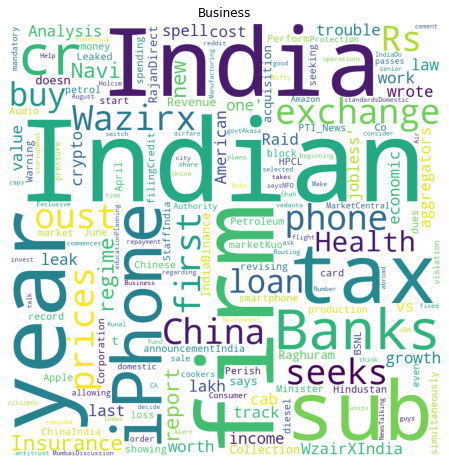

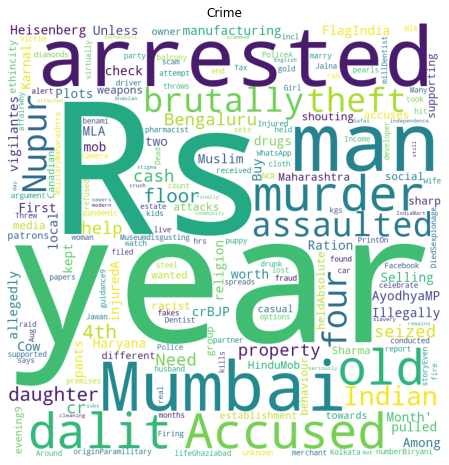

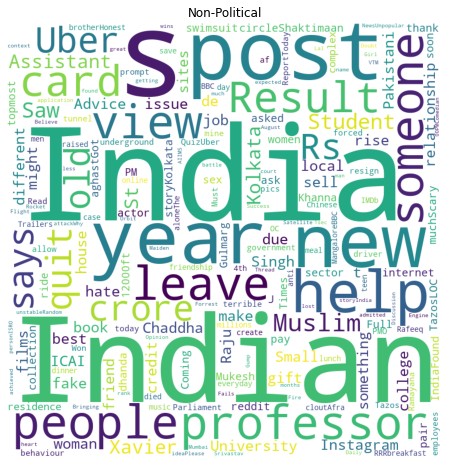

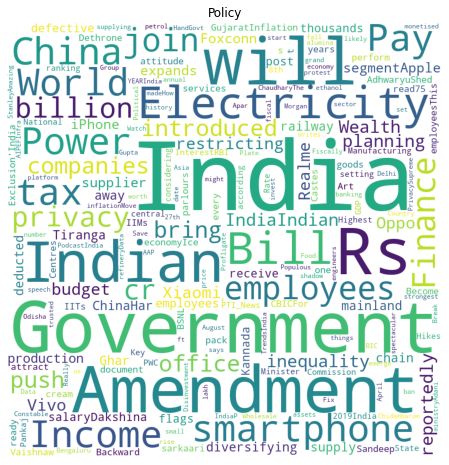

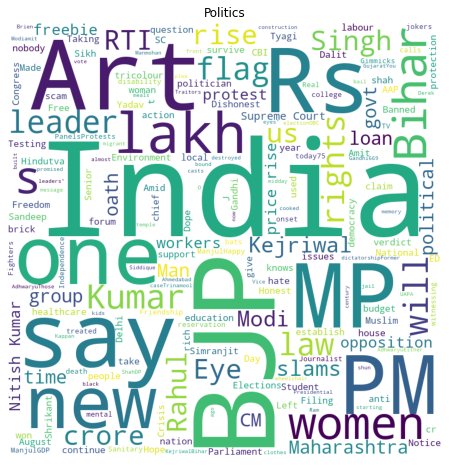

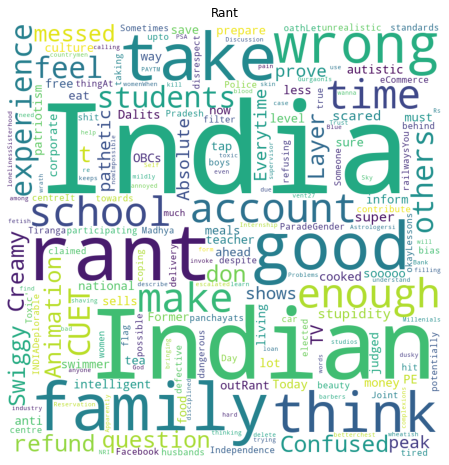

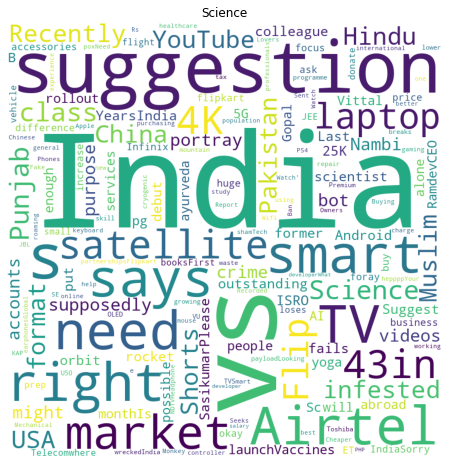

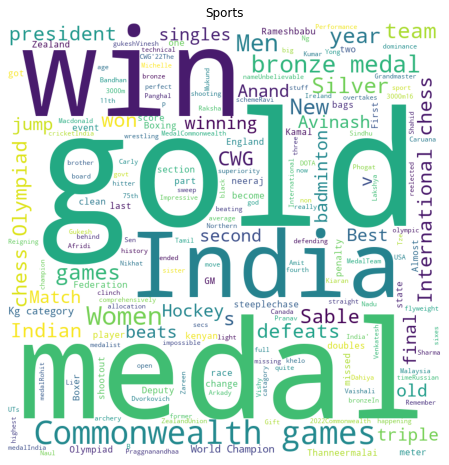

In [15]:
flairs = list(set(dataset['Flair']))
for flair in flairs:
    get_visuals(dataset,'Flair',flair)

In [16]:
# based on this, we can see the word 'India' and 'Indian' appear in (almost) all categories.
# hence dropping them.

In [17]:
# data preprocessing
def prepare_data(df,column_name):
    data=df[column_name]
    useless_words=list(stopwords.words('english')+list(punctuation)+['India','Indian'])
    
    lemmatizer=WordNetLemmatizer()
    corpus=data.tolist()
    final_corpus=[]
    
    for i in range(len(corpus)):
        word=word_tokenize(corpus[i].lower())
        word=[
            lemmatizer.lemmatize(y) for y in word if y not in useless_words
        ]
        j=" ".join(word)
        j=re.sub(r'[^\w\s]', " ", j)
        j=re.sub("(^|\W)\d+"," ",j)
        
        final_corpus.append(j)
    
    return final_corpus

In [18]:
final_corpus=prepare_data(dataset,'Title')

label_=dataset['Flair']
train_df={
    'label':label_,
    'content':final_corpus,
}

train_df=pd.DataFrame(train_df)
train_df.head()

,label,content
1,7,avinash sable remember name
2,6,science class punjab
3,4,freedom fighter would treated today
4,7,unbelievable stuff happening commonwealth game...
5,7,medal commonwealth game india gold silve...


In [19]:
train_df['label'].value_counts()

4    102
2     86
5     60
3     45
7     39
0     29
6     29
1     27
Name: label, dtype: int64

In [20]:
# biased distribution. Resampling to make it non biased.
df_top = train_df[(train_df['label']== 4)]
df_1 = train_df[(train_df['label']== 2)]
df_2 = train_df[(train_df['label']== 5)]
df_3 = train_df[(train_df['label']==3)]
df_4 = train_df[(train_df['label']==7)]
df_5 = train_df[(train_df['label']==0)]
df_6 = train_df[(train_df['label']==6)]
df_7 = train_df[(train_df['label']==1)]

# upsample minority classes
df_1_upsampled = resample(df_1, 
                          replace=True,    
                          n_samples= 102, 
                          random_state=42)  

df_2_upsampled = resample(df_2, 
                          replace=True,    
                          n_samples= 102, 
                          random_state=42)

df_3_upsampled = resample(df_3, 
                          replace=True,    
                          n_samples= 102, 
                          random_state=42)

df_4_upsampled = resample(df_4, 
                          replace=True,    
                          n_samples= 102, 
                          random_state=42)

df_5_upsampled = resample(df_5, 
                          replace=True,    
                          n_samples= 102, 
                          random_state=42)
df_6_upsampled = resample(df_6, 
                          replace=True,    
                          n_samples= 102, 
                          random_state=42)

df_7_upsampled = resample(df_7, 
                          replace=True,    
                          n_samples= 102, 
                          random_state=42)

# Concatenate the upsampled dataframes with the neutral dataframe
df_final = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,
                     df_5_upsampled,df_6_upsampled,df_7_upsampled,df_top])

In [21]:
df_final.head()

,label,content
496,2,baby name
135,2,case fake imdb credit indian men create fake o...
742,2,best credit card get
607,2,bengaluru chennai hour know green expressway
173,2,please believe


In [22]:
df_final['label'].value_counts()

0    102
1    102
2    102
3    102
4    102
5    102
6    102
7    102
Name: label, dtype: int64

In [23]:
tf=TfidfVectorizer()
vector=tf.fit_transform(train_df['content'])
x=vector.toarray()
y=train_df['label']

x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=101)

In [25]:
model = MultinomialNB()

model.fit(x_train,y_train)
y_preds = model.predict(x_test)

report = classification_report(y_test,y_preds)
score = accuracy_score(y_test,y_preds)

print('='*50,'Baseline Model','='*50)
print(f'Naive Bayes :\nClassifiacation Report -> \n{report}\nAccuracy -> {score}')

================================================== Baseline Model ==================================================
Naive Bayes :
Classifiacation Report -> 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         6
           2       0.60      0.26      0.36        23
           3       0.00      0.00      0.00        12
           4       0.22      1.00      0.37        15
           5       0.50      0.12      0.20         8
           6       0.00      0.00      0.00         7
           7       1.00      0.71      0.83         7

    accuracy                           0.32        84
   macro avg       0.29      0.26      0.22        84
weighted avg       0.34      0.32      0.25        84

Accuracy -> 0.32142857142857145


In [26]:
model = RandomForestClassifier()

model.fit(x_train,y_train)
y_preds = model.predict(x_test)

report = classification_report(y_test,y_preds)
score = accuracy_score(y_test,y_preds)

print('='*50,'RandomForest Classifier','='*50)
print(f'Classifiacation Report -> \n{report}\nAccuracy -> {score}')

================================================== RandomForest Classifier ==================================================
Classifiacation Report -> 
              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.00      0.00      0.00         6
           2       0.33      0.70      0.45        23
           3       0.67      0.17      0.27        12
           4       0.57      0.53      0.55        15
           5       0.11      0.12      0.12         8
           6       0.00      0.00      0.00         7
           7       1.00      0.86      0.92         7

    accuracy                           0.40        84
   macro avg       0.37      0.32      0.31        84
weighted avg       0.40      0.40      0.36        84

Accuracy -> 0.40476190476190477


In [27]:
model = XGBClassifier()

model.fit(x_train,y_train)
y_preds = model.predict(x_test)

report = classification_report(y_test,y_preds)
score = accuracy_score(y_test,y_preds)

print('='*50,'RandomForest Classifier','='*50)
print(f'Classifiacation Report -> \n{report}\nAccuracy -> {score}')

[15:00:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
================================================== RandomForest Classifier ==================================================
Classifiacation Report -> 
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.00      0.00      0.00         6
           2       0.33      0.52      0.41        23
           3       0.38      0.25      0.30        12
           4       0.38      0.40      0.39        15
           5       0.00      0.00      0.00         8
           6       0.40      0.29      0.33         7
           7       0.71      0.71      0.71         7

    accuracy                           0.36     

In [28]:
# Deep learning models

In [29]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1873 unique tokens.


In [30]:
X = tokenizer.texts_to_sequences(train_df['content'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (417, 250)


In [31]:
Y = pd.get_dummies(train_df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (417, 8)


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 101)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(333, 250) (333, 8)
(84, 250) (84, 8)


In [33]:
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))
model.add(keras.layers.LSTM(75, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 75)                52800     
                                                                 
 dense (Dense)               (None, 8)                 608       
                                                                 
Total params: 5,053,408
Trainable params: 5,053,408
Non-trainable params: 0
_________________________________________________________________


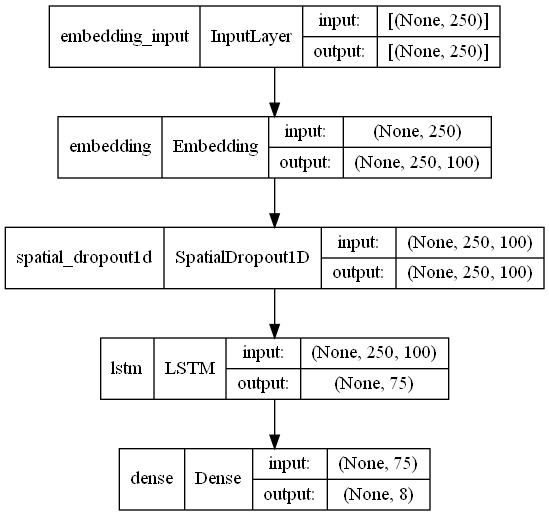

In [35]:
plot_model(model,show_shapes=True,show_layer_names=True)

In [36]:
epochs = 8
batch_size = 16

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/8
17/17 [==============================] - 6s 256ms/step - loss: 2.0477 - accuracy: 0.2218 - val_loss: 1.9934 - val_accuracy: 0.2687
Epoch 2/8
17/17 [==============================] - 4s 207ms/step - loss: 1.9544 - accuracy: 0.2594 - val_loss: 1.9833 - val_accuracy: 0.2687
Epoch 3/8
17/17 [==============================] - 3s 202ms/step - loss: 1.8938 - accuracy: 0.2669 - val_loss: 1.9749 - val_accuracy: 0.2687
Epoch 4/8
17/17 [==============================] - 3s 203ms/step - loss: 1.8192 - accuracy: 0.2782 - val_loss: 1.9172 - val_accuracy: 0.3582
Epoch 5/8
17/17 [==============================] - 3s 197ms/step - loss: 1.6990 - accuracy: 0.3985 - val_loss: 1.8569 - val_accuracy: 0.3731
Epoch 6/8
17/17 [==============================] - 3s 195ms/step - loss: 1.5234 - accuracy: 0.4962 - val_loss: 1.7634 - val_accuracy: 0.3881
Epoch 7/8
17/17 [==============================] - 3s 200ms/step - loss: 1.2357 - accuracy: 0.6466 - val_loss: 1.6764 - val_accuracy: 0.4179
Epoch 8/8
17/

In [37]:
def get_plot(trained_model,no_epochs):
    accuracy=trained_model.history['accuracy']
    loss=trained_model.history['loss']
    val_accuracy=trained_model.history['val_accuracy']
    val_loss=trained_model.history['val_loss']
    epochs=[i for i in range(1,no_epochs+1)]

    plt.figure(figsize=(12,8))
    plt.plot(epochs,accuracy,'r',label='Training')
    plt.plot(epochs,val_accuracy,'--',label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy',fontsize=15)
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(epochs,loss,'r',label='Training')
    plt.plot(epochs,val_loss,'--',label='Validation')
    plt.legend()
    plt.title('Loss',fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

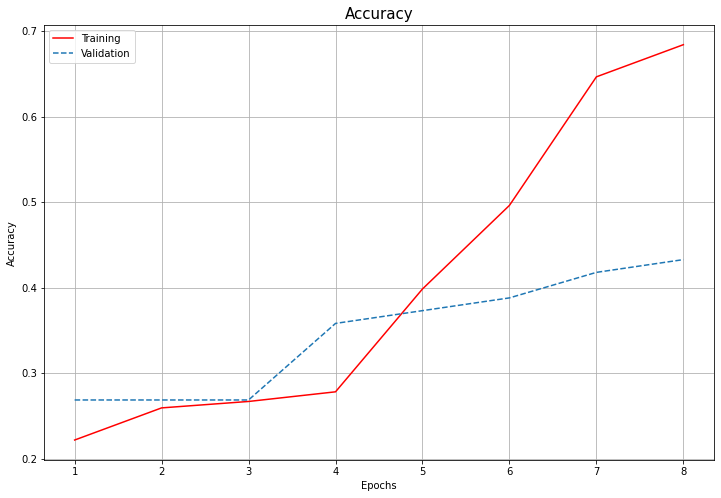

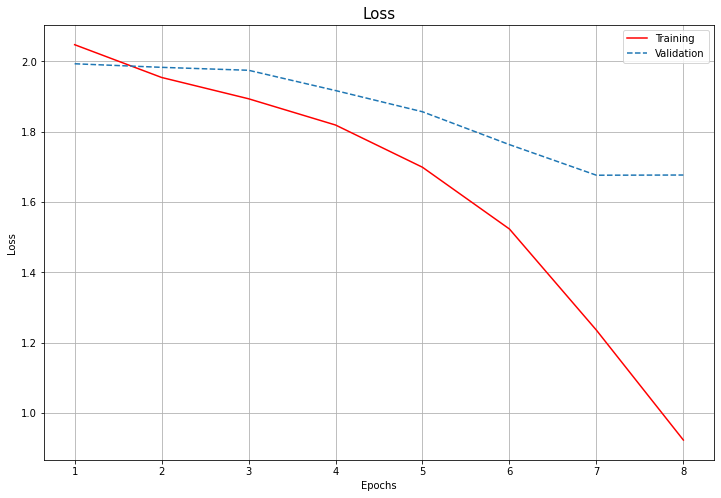

In [38]:
get_plot(history,8)

In [44]:
# The model starts to overfit after the 5th epoch

# Overfitting can be reduced by : (i) Decreasing Complexity 
7
#                                 (ii) Increasing Data 

In [40]:
predictions = model.predict(X_test)
preds = []

for i in predictions:
    preds.append(np.argmax(i))

preds= np.asarray(preds)

In [41]:
labels = []
for i in Y_test:
    labels.append(np.argmax(i))
    
labels = np.asarray(labels)
labels = labels.reshape(84,)
labels

array([0, 4, 0, 5, 7, 3, 6, 2, 4, 5, 2, 5, 1, 6, 4, 3, 2, 2, 3, 6, 1, 0,
       0, 2, 5, 4, 2, 6, 3, 3, 2, 6, 5, 2, 3, 2, 7, 6, 0, 2, 6, 2, 2, 4,
       4, 4, 4, 2, 3, 2, 2, 4, 7, 4, 4, 5, 1, 3, 2, 1, 5, 4, 4, 1, 7, 4,
       2, 4, 7, 2, 2, 5, 2, 3, 3, 2, 0, 2, 3, 3, 7, 7, 2, 1], dtype=int64)

In [42]:
print(classification_report(preds,labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.57      0.31      0.40        42
           3       0.00      0.00      0.00         0
           4       0.87      0.50      0.63        26
           5       0.25      0.25      0.25         8
           6       0.00      0.00      0.00         0
           7       0.86      0.75      0.80         8

    accuracy                           0.40        84
   macro avg       0.32      0.23      0.26        84
weighted avg       0.66      0.40      0.50        84



In [43]:
accuracy_score(preds,labels)

0.40476190476190477